In [261]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

In [262]:
integrator = {
    'type': 'direct_reparam',
}

In [263]:
scene = mi.load_file('../scenes/editing-a-scene/cbox.xml')

In [264]:
image_ref = mi.render(scene, spp=256)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [265]:
params = mi.traverse(scene)

reflectanceKeys = ['light.emitter.radiance.value']

# Save the original value
param_refs = dict(zip(reflectanceKeys, [mi.Color3f(params[key]) for key in reflectanceKeys]))

# Initialize the random number generator
numOfChannels = 3
rng = mi.PCG32(size=numOfChannels * len(param_refs))
samples = rng.next_float64() * 50.0

# Set another color value and update the scene
for i, key in enumerate(reflectanceKeys):
    params[key] = mi.Color3f(
        samples[i*numOfChannels], samples[i*numOfChannels+1], samples[i*numOfChannels+2])

params.update();


In [266]:
# reflactence optimizer
reflectanceOpt = mi.ad.Adam(lr=0.6)
for key in reflectanceKeys:
    reflectanceOpt[key] = params[key]
params.update(reflectanceOpt);

In [267]:
img_init = mi.render(scene, spp=256) # seed = 0 missing
mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [268]:
def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

In [269]:
iteration_count = 300
minError = 0.0009

In [270]:
loss_hist = []
err_refs = dict(zip(reflectanceKeys, dr.full(mi.Float,  dr.inf, len(reflectanceKeys))))

In [271]:
for it in range(iteration_count):

    # check all optimization parameters and if defined threshold is achieved
    # stop optimization for that parameter
    # TODO currently dirty
    shouldStop = True
    for key in err_refs:
        if err_refs[key] < minError:
            if key in reflectanceOpt:
                reflectanceOpt.variables.pop(key)
                print('Resetted optimization:', key)
            shouldStop = shouldStop & True
        else:
            shouldStop = False

    # stop optimization if all optimization parameters achieved to reach some
    # defined threshold
    if shouldStop:
        break


    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, seed=it, spp=16)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)
    # loss = dr.sum(dr.sqr(image - image_ref)) / len(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    reflectanceOpt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in reflectanceKeys:
        if key in reflectanceOpt:
            reflectanceOpt[key] = dr.clamp(reflectanceOpt[key], 0.0, 50.0)

    # Update the scene state to the new optimized values
    params.update(reflectanceOpt)

    print(f"Iteration {it:02d}")
    for key in param_refs:
        tmp = params[key]
        err_ref = dr.sum(dr.sqr(param_refs[key] - tmp))
        err_refs[key] = err_ref[0]
        print(f"\tkey= {key} error= {err_ref[0]:6f}")
    loss_hist.append(loss)
    # print(f"Iteration {it:02d}:  error={loss[0]:6f}", end='\r')
print('\nOptimization complete.')

Iteration 00
	key= light.emitter.radiance.value error= 1890.244995
Iteration 01
	key= light.emitter.radiance.value error= 1820.407349
Iteration 02
	key= light.emitter.radiance.value error= 1752.825439
Iteration 03
	key= light.emitter.radiance.value error= 1687.519531
Iteration 04
	key= light.emitter.radiance.value error= 1624.505127
Iteration 05
	key= light.emitter.radiance.value error= 1563.779541
Iteration 06
	key= light.emitter.radiance.value error= 1505.329468
Iteration 07
	key= light.emitter.radiance.value error= 1449.122681
Iteration 08
	key= light.emitter.radiance.value error= 1395.098999
Iteration 09
	key= light.emitter.radiance.value error= 1343.188232
Iteration 10
	key= light.emitter.radiance.value error= 1293.298706
Iteration 11
	key= light.emitter.radiance.value error= 1245.321899
Iteration 12
	key= light.emitter.radiance.value error= 1199.139526
Iteration 13
	key= light.emitter.radiance.value error= 1154.631348
Iteration 14
	key= light.emitter.radiance.value error= 1111.67

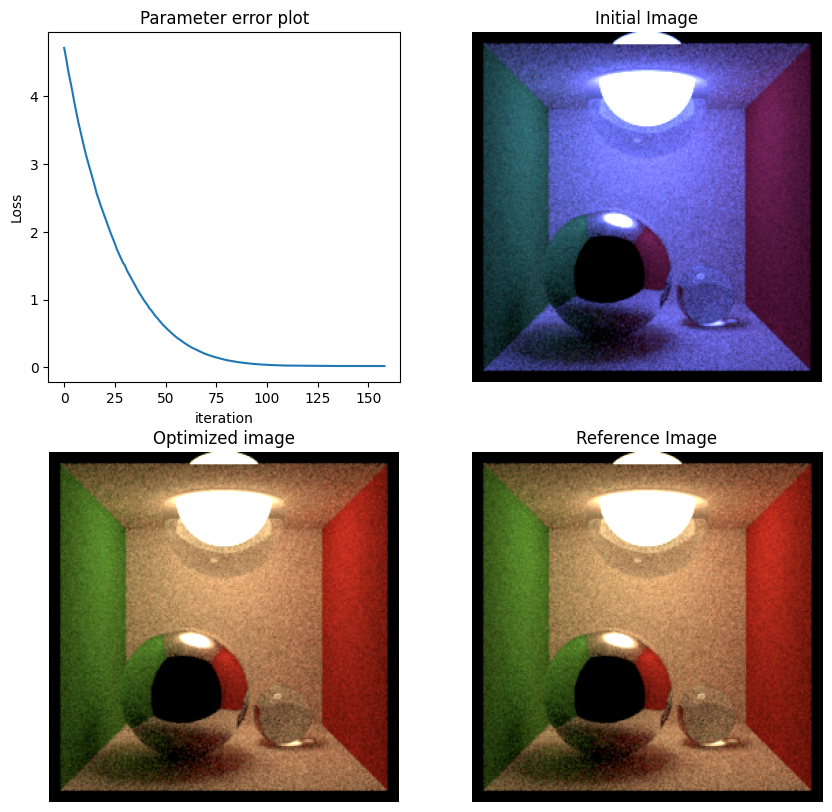

In [272]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(image_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

fig.savefig('optimization-test-figure.png')

In [273]:
params['light.emitter.radiance.value']

[[18.39438247680664, 13.993080139160156, 6.779733180999756]]